# Отток клиентов

Имея данные о поведении клиентов и расторжении договоров с банком, нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  

Необходимо построить модель с предельно большим значением *F1*-меры, дополнительно измерять *AUC-ROC*, и сравнивать её значение с *F1*-мерой.

Для подготовки данных используем прямое кодирование (OHE), масштабирование признаков, борьба с дисбалансом классов (взвешивание классов, увеличение и уменьшение выборки).

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')

In [ ]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**Описание данных**


Признаки: 
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата



Целевой признак:
* Exited — факт ухода клиента

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски только в столбце Tenure — сколько лет человек является клиентом банка. Типы данных корректные.

In [ ]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Заполним пропуски в столбце Tenure нулями, исходя из предположения, что пропуски означают, что человек является клиентом банка не полный год.

In [ ]:
df['Tenure'] = df['Tenure'].fillna(0)
df['Tenure'].isna().sum()

0

In [ ]:
df.duplicated().sum()

0

Явных дубликатов нет.

Для дальнейшего анализа и обучения удалим столцбы, не несущие полезной информации для целей обучения моделей.

In [ ]:
df_ml = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
df_ml

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Применим прямое кодирование (One-Hot Encoding, OHE).

In [ ]:
df_ml_ohe = pd.get_dummies(df_ml, drop_first=True)

In [ ]:
df_ml_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Разделим исходные данные на обучающую, валидационную и тестовую выборки.

Делим выборку в отношении 3 : 1 : 1

In [ ]:
features = df_ml_ohe.drop(['Exited'], axis=1) # извлечем признаки
target = df_ml_ohe['Exited'] # извлечем целевой признак

In [ ]:
features.shape

(10000, 11)

In [ ]:
target.shape

(10000,)

In [ ]:
# отделим 20% данных для тестовой выборки
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) 

In [ ]:
features_test.shape # признаки, тестовая выборка

(2000, 11)

In [ ]:
target_test.shape # целевой признак, тестовая выборка

(2000,)

In [ ]:
# отделим 25% данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345) 

In [ ]:
features_train.shape # признаки, тренировочная выборка

(6000, 11)

In [ ]:
target_train.shape # целевой признак, тренировочная выборка

(6000,)

In [ ]:
features_valid.shape # признаки, валидационная выборка

(2000, 11)

In [ ]:
target_valid.shape # целевой признак, валидационная выборка

(2000,)

Масштабируем численные признаки

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

In [ ]:
scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
features_train.shape

(6000, 11)

In [ ]:
features_valid.shape

(2000, 11)

In [ ]:
features_test.shape

(2000, 11)

## Исследование задачи

Исследуем баланс классов

In [ ]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Классы несбалансированны.

0 - клиент не ушел

1 - клиент ушел

Изучим модели без учёта дисбаланса классов

### Дерево решений

In [ ]:
data = []
col = ['model', 'F1', 'AUC_ROC', 'depth', 'est']

In [ ]:
best_model_DT = None
best_f1 = 0
best_depth = 0

for depth in range(1, 11): # в цикле меняем гиперпараметр - максимальную глубину дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # модель - дерево решений, с заданной глубиной дерева
    model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
    predictions = model.predict(features_valid) # предсказания на валидационной выборке
    f1 = f1_score(target_valid, predictions) # f1
    if f1 > best_f1:
        probabilities_valid = model.predict_proba(features_valid) # вероятность классов
        probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
        best_model_DT = model
        best_f1 = f1
        best_depth = depth
        
print("F1 лучшей модели 'Дерево решений' на валидационной выборке:", best_f1, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Дерево решений' на валидационной выборке:", auc_roc)

data.append(['DecTreeClass', best_f1, auc_roc, best_depth, '-'])

F1 лучшей модели 'Дерево решений' на валидационной выборке: 0.5488958990536277 Глубина дерева: 7
auc_roc лучшей модели 'Дерево решений' на валидационной выборке: 0.8275652142122556


### Случайный лес

In [ ]:
best_model_RF = None
best_f1 = 0
best_depth = 0
best_est = 0

for est in range(1, 21): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 15): # в цикле меняем гиперпараметр - максимальную глубину дерева
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # модель - случайный лес, с заданным количеством деревьев и заданной глубиной дерева
        model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
        predictions = model.predict(features_valid) # предсказания на валидационной выборке
        f1 = f1_score(target_valid, predictions) # f1
        if f1 > best_f1:
            probabilities_valid = model.predict_proba(features_valid) # вероятность классов
            probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
            best_model_RF = model
            best_f1 = f1
            best_depth = depth
            best_est = est
        
print("F1 лучшей модели 'Случайный лес' на валидационной выборке:", best_f1, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Случайный лес' на валидационной выборке:", auc_roc)

data.append(['RandForClass', best_f1, auc_roc, best_depth, best_est])

F1 лучшей модели 'Случайный лес' на валидационной выборке: 0.5714285714285714 Количество деревьев: 13 Глубина дерева: 12
auc_roc лучшей модели 'Случайный лес' на валидационной выборке: 0.8268101901230133


### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state=12345) # модель логистической регрессии с параметром random_state=12345
model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
predictions = model.predict(features_valid) # предсказания на валидационной выборке
f1 = f1_score(target_valid, predictions) # f1
probabilities_valid = model.predict_proba(features_valid) # вероятность классов
probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc

print("F1 модели логистической регрессии на валидационной выборке:", f1)
print("auc_roc модели логистической регрессии на валидационной выборке:", auc_roc)

data.append(['LogRegress', f1, auc_roc, '-', '-'])

F1 модели логистической регрессии на валидационной выборке: 0.3056603773584906
auc_roc модели логистической регрессии на валидационной выборке: 0.7707603807864648


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,F1,AUC_ROC,depth,est
0,DecTreeClass,0.548896,0.827565,7,-
1,RandForClass,0.571429,0.826810,12,13
2,LogRegress,0.305660,0.770760,-,-


Лучший показатель F1-меры при дисбалансе классов получен на модели случайный лес: 0.5714285714285714. Количество деревьев: 13 Глубина дерева: 12.

При этом auc_roc: 0.8268101901230133. Чуть хуже результаты модели 'Дерево решений'.

## Борьба с дисбалансом

### Взвешивание классов

#### Дерево решений

In [ ]:
best_model_DTCB = None
best_f1 = 0
best_depth = 0

for depth in range(1, 11): # в цикле меняем гиперпараметр - максимальную глубину дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # модель - дерево решений, с заданной глубиной дерева
    model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
    predictions = model.predict(features_valid) # предсказания на валидационной выборке
    f1 = f1_score(target_valid, predictions) # f1
    if f1 > best_f1:
        probabilities_valid = model.predict_proba(features_valid) # вероятность классов
        probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
        best_model_DTCB = model
        best_f1 = f1
        best_depth = depth
        
print("F1 лучшей модели 'Дерево решений, взвеш.кл.' на валидационной выборке:", best_f1, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Дерево решений, взвеш.кл.' на валидационной выборке:", auc_roc)

data.append(['DecTreeClassBal', best_f1, auc_roc, best_depth, '-'])

F1 лучшей модели 'Дерево решений, взвеш.кл.' на валидационной выборке: 0.5587044534412956 Глубина дерева: 6
auc_roc лучшей модели 'Дерево решений, взвеш.кл.' на валидационной выборке: 0.8089018134883863


#### Случайный лес

In [ ]:
best_model_RFCB = None
best_f1 = 0
best_depth = 0
best_est = 0

for est in range(1, 21): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 15): # в цикле меняем гиперпараметр - максимальную глубину дерева
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # модель - случайный лес, с заданным количеством деревьев и заданной глубиной дерева
        model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
        predictions = model.predict(features_valid) # предсказания на валидационной выборке
        f1 = f1_score(target_valid, predictions) # f1
        if f1 > best_f1:
            probabilities_valid = model.predict_proba(features_valid) # вероятность классов
            probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
            best_model_RFCB = model
            best_f1 = f1
            best_depth = depth
            best_est = est
        
print("F1 лучшей модели 'Случайный лес, взвеш.кл.' на валидационной выборке:", best_f1, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Случайный лес, взвеш.кл.' на валидационной выборке:", auc_roc)

data.append(['RandForClassBal', best_f1, auc_roc, best_depth, best_est])

F1 лучшей модели 'Случайный лес, взвеш.кл.' на валидационной выборке: 0.5931758530183727 Количество деревьев: 19 Глубина дерева: 11
auc_roc лучшей модели 'Случайный лес, взвеш.кл.' на валидационной выборке: 0.8484475909962981


#### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') # модель логистической регрессии с параметром random_state=12345
model.fit(features_train, target_train) # алгоритм обучения - на выходе обученная модель на тренировочной выборке
predictions = model.predict(features_valid) # предсказания на валидационной выборке
f1 = f1_score(target_valid, predictions) # f1
probabilities_valid = model.predict_proba(features_valid) # вероятность классов
probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc

print("F1 модели логистической регрессии, взвеш.кл. на валидационной выборке:", f1)
print("auc_roc модели логистической регрессии, взвеш.кл. на валидационной выборке:", auc_roc)

data.append(['LogRegressBal', f1, auc_roc, '-', '-'])

F1 модели логистической регрессии, взвеш.кл. на валидационной выборке: 0.47763864042933807
auc_roc модели логистической регрессии, взвеш.кл. на валидационной выборке: 0.7729507454074667


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,F1,AUC_ROC,depth,est
0,DecTreeClass,0.548896,0.827565,7,-
1,RandForClass,0.571429,0.826810,12,13
2,LogRegress,0.305660,0.770760,-,-
3,DecTreeClassBal,0.558704,0.808902,6,-
4,RandForClassBal,0.593176,0.848448,11,19
5,LogRegressBal,0.477639,0.772951,-,-


Лучший показатель F1-меры при взвешивании классов получен на модели случайный лес: 0.5931758530183727. Количество деревьев: 19 Глубина дерева: 11.

При этом auc_roc: 0.8484475909962981. 

По сравнению с дисбалансом показатели улучшились.

### Увеличение выборки

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 6)

#### Дерево решений

In [ ]:
best_model_DTUP = None
best_f1 = 0
best_depth = 0

for depth in range(1, 11): # в цикле меняем гиперпараметр - максимальную глубину дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # модель - дерево решений, с заданной глубиной дерева
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid) # предсказания на валидационной выборке
    f1 = f1_score(target_valid, predictions) # f1
    if f1 > best_f1:
        probabilities_valid = model.predict_proba(features_valid) # вероятность классов
        probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
        best_model_DTUP = model
        best_f1 = f1
        best_depth = depth
        
print("F1 лучшей модели 'Дерево решений' на увеличенной выборке, взвеш.кл.:", best_f1, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Дерево решений' на увеличенной выборке, взвеш.кл.:", auc_roc)

data.append(['DecTreeClassUP', best_f1, auc_roc, best_depth, '-'])

F1 лучшей модели 'Дерево решений' на увеличенной выборке, взвеш.кл.: 0.5587044534412956 Глубина дерева: 6
auc_roc лучшей модели 'Дерево решений' на увеличенной выборке, взвеш.кл.: 0.8089065820615813


#### Случайный лес

In [ ]:
best_model_RF_up = None
best_f1_up = 0
best_depth_up = 0
best_est_up = 0

for est in range(1, 22): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 15): # в цикле меняем гиперпараметр - максимальную глубину дерева
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # модель - случайный лес, с заданным количеством деревьев и заданной глубиной дерева
        model.fit(features_upsampled, target_upsampled) # алгоритм обучения - на выходе обученная модель 
        predictions = model.predict(features_valid) # предсказания на валидационной выборке
        f1 = f1_score(target_valid, predictions) # f1
        if f1 > best_f1_up:
            probabilities_valid = model.predict_proba(features_valid) # вероятность классов
            probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
            auc_roc_up = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
            best_model_RF_up = model
            best_f1_up = f1
            best_depth_up = depth
            best_est_up = est
        
print("F1 лучшей модели 'Случайный лес' на увеличенной выборке, взвеш.кл.:", best_f1_up, "Количество деревьев:", best_est_up, "Глубина дерева:", best_depth_up)
print("auc_roc лучшей модели 'Случайный лес', на увеличенной выборке, взвеш.кл.", auc_roc_up)

data.append(['RandForClassUP', best_f1_up, auc_roc_up, best_depth_up, best_est_up])

F1 лучшей модели 'Случайный лес' на увеличенной выборке, взвеш.кл.: 0.6018306636155607 Количество деревьев: 20 Глубина дерева: 10
auc_roc лучшей модели 'Случайный лес', на увеличенной выборке, взвеш.кл. 0.848620054393525


#### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') # модель логистической регрессии с параметром random_state=12345
model.fit(features_upsampled, target_upsampled) # алгоритм обучения - на выходе обученная модель 
predictions = model.predict(features_valid) # предсказания на валидационной выборке
f1 = f1_score(target_valid, predictions) # f1
probabilities_valid = model.predict_proba(features_valid) # вероятность классов
probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc

print("F1 модели логистической регрессии на увеличенной выборке, взвеш.кл.:", f1)
print("auc_roc модели логистической регрессии на увеличенной выборке, взвеш.кл.:", auc_roc)

data.append(['LogRegressUP', f1, auc_roc, '-', '-'])

F1 модели логистической регрессии на увеличенной выборке, взвеш.кл.: 0.47763864042933807
auc_roc модели логистической регрессии на увеличенной выборке, взвеш.кл.: 0.7729857149442315


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,F1,AUC_ROC,depth,est
0,DecTreeClass,0.548896,0.827565,7,-
1,RandForClass,0.571429,0.826810,12,13
2,LogRegress,0.305660,0.770760,-,-
3,DecTreeClassBal,0.558704,0.808902,6,-
4,RandForClassBal,0.593176,0.848448,11,19
5,LogRegressBal,0.477639,0.772951,-,-
6,DecTreeClassUP,0.558704,0.808907,6,-
7,RandForClassUP,0.601831,0.848620,10,20
8,LogRegressUP,0.477639,0.772986,-,-


Лучший показатель F1-меры при увеличении выборки и взвешивании классов получен на модели случайный лес: 0.6018306636155607. Количество деревьев: 20 Глубина дерева: 10.

При этом auc_roc: 0.848620054393525. 

По сравнению с взвешиванием классов показатели улучшились.

При попытке увеличения выборки и не использовании взвешивания классов показатели ухудшаются.

### Уменьшение выборки

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

#### Дерево решений

In [ ]:
best_model_DT = None
best_f1 = 0
best_depth = 0

for depth in range(1, 11): # в цикле меняем гиперпараметр - максимальную глубину дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # модель - дерево решений, с заданной глубиной дерева
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid) # предсказания на валидационной выборке
    f1 = f1_score(target_valid, predictions) # f1
    if f1 > best_f1:
        probabilities_valid = model.predict_proba(features_valid) # вероятность классов
        probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
        best_model_DT = model
        best_f1 = f1
        best_depth = depth
        
print("F1 лучшей модели 'Дерево решений' на уменьшенной выборке:", best_f1, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Дерево решений' на уменьшенной выборке:", auc_roc)

data.append(['DecTreeClassDown', best_f1, auc_roc, best_depth, '-'])

F1 лучшей модели 'Дерево решений' на уменьшенной выборке: 0.5717073170731707 Глубина дерева: 6
auc_roc лучшей модели 'Дерево решений' на уменьшенной выборке: 0.8298763826875359


#### Случайный лес

In [ ]:
best_model_RF = None
best_f1 = 0
best_depth = 0
best_est = 0

for est in range(1, 21): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 15): # в цикле меняем гиперпараметр - максимальную глубину дерева
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # модель - случайный лес, с заданным количеством деревьев и заданной глубиной дерева
        model.fit(features_downsampled, target_downsampled) # алгоритм обучения - на выходе обученная модель 
        predictions = model.predict(features_valid) # предсказания на валидационной выборке
        f1 = f1_score(target_valid, predictions) # f1
        if f1 > best_f1:
            probabilities_valid = model.predict_proba(features_valid) # вероятность классов
            probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc
            best_model_RF = model
            best_f1 = f1
            best_depth = depth
            best_est = est
        
print("F1 лучшей модели 'Случайный лес' на уменьшенной выборке:", best_f1, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)
print("auc_roc лучшей модели 'Случайный лес, на уменьшенной выборке:", auc_roc)

data.append(['RandForClassDown', best_f1, auc_roc, best_depth, best_est])

F1 лучшей модели 'Случайный лес' на уменьшенной выборке: 0.5826944140197152 Количество деревьев: 9 Глубина дерева: 6
auc_roc лучшей модели 'Случайный лес, на уменьшенной выборке: 0.8374703355009148


#### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear') # модель логистической регрессии с параметром random_state=12345
model.fit(features_downsampled, target_downsampled) # алгоритм обучения - на выходе обученная модель 
predictions = model.predict(features_valid) # предсказания на валидационной выборке
f1 = f1_score(target_valid, predictions) # f1
probabilities_valid = model.predict_proba(features_valid) # вероятность классов
probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1» 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # auc_roc

print("F1 модели логистической регрессии на уменьшенной выборке:", f1)
print("auc_roc модели логистической регрессии на уменьшенной выборке.:", auc_roc)

data.append(['LogRegressDown', f1, auc_roc, '-', '-'])

F1 модели логистической регрессии на уменьшенной выборке: 0.48880233690360275
auc_roc модели логистической регрессии на уменьшенной выборке.: 0.7733560741290599


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,F1,AUC_ROC,depth,est
0,DecTreeClass,0.548896,0.827565,7,-
1,RandForClass,0.571429,0.826810,12,13
2,LogRegress,0.305660,0.770760,-,-
3,DecTreeClassBal,0.558704,0.808902,6,-
4,RandForClassBal,0.593176,0.848448,11,19
5,LogRegressBal,0.477639,0.772951,-,-
6,DecTreeClassUP,0.558704,0.808907,6,-
7,RandForClassUP,0.601831,0.848620,10,20
8,LogRegressUP,0.477639,0.772986,-,-
9,DecTreeClassDown,0.571707,0.829876,6,-


Лучший показатель F1-меры при уменьшении выборки получен на модели случайный лес: 0.5826944140197152. Количество деревьев: 9 Глубина дерева: 6. При этом auc_roc: 0.8374703355009148.

По сравнению с увеличением выборки и взвешиванием классов показатели ухудшились.

При попытке уменьшения выборки и взвешивании классов показатели ухудшаются.

## Тестирование модели

Тестирование проведем на модели показавшей лучшие результаты: 'случайный лес' при увеличении выборки и взвешивании классов. Количество деревьев: 20 Глубина дерева: 10.

In [ ]:
predictions = best_model_RF_up.predict(features_test) # предсказания на тестовой выборке
#predictions = best_model_RFCB.predict(features_test) # предсказания на тестовой выборке
f1 = f1_score(target_test, predictions) # f1
probabilities_test = best_model_RF_up.predict_proba(features_test) # вероятность классов
#probabilities_test = best_model_RFCB.predict_proba(features_test) # вероятность классов
probabilities_one_test = probabilities_test[:, 1] # значения вероятностей класса «1» 
auc_roc = roc_auc_score(target_test, probabilities_one_test) # auc_roc
        
print("F1 лучшей модели 'Случайный лес' на тестовой выборке:", f1, "Количество деревьев:", best_est_up, "Глубина дерева:", best_depth_up)
print("auc_roc лучшей модели 'Случайный лес' на тестовой выборке:", auc_roc)

data.append(['-', '-', '-', '-', '-'])
data.append(['BEST_model_test', f1, auc_roc, best_depth_up, best_est_up])

F1 лучшей модели 'Случайный лес' на тестовой выборке: 0.6320254506892895 Количество деревьев: 20 Глубина дерева: 10
auc_roc лучшей модели 'Случайный лес' на тестовой выборке: 0.8620857532929068


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,F1,AUC_ROC,depth,est
0,DecTreeClass,0.548896,0.827565,7,-
1,RandForClass,0.571429,0.82681,12,13
2,LogRegress,0.30566,0.77076,-,-
3,DecTreeClassBal,0.558704,0.808902,6,-
4,RandForClassBal,0.593176,0.848448,11,19
5,LogRegressBal,0.477639,0.772951,-,-
6,DecTreeClassUP,0.558704,0.808907,6,-
7,RandForClassUP,0.601831,0.84862,10,20
8,LogRegressUP,0.477639,0.772986,-,-
9,DecTreeClassDown,0.571707,0.829876,6,-


На тестовой выборке лучшей моделью получена F1-мера = 0.6320254506892589, auc_roc=0.8620857532929068.

Дополнительно.

При заполнении пропусков в столбце Tenure на медианное значение в зависимости от возраста результат хуже:

F1-мера лучшей модели 'Случайный лес' при взвешивании классов на тестовой выборке: 0.6178861788617885, auc_roc=0.8488731834484442. 

## Исследование важности признаков

In [ ]:
feature_names = features_test.columns

In [ ]:
import time

start_time = time.time()
importances = best_model_RF_up.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model_RF_up.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


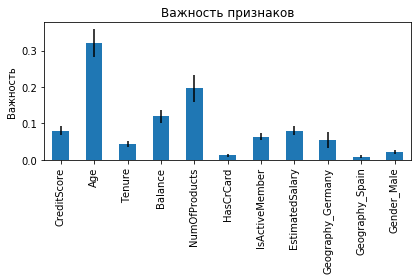

In [ ]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Важность")
fig.tight_layout()

Важными оказались признаки:

* Age — возраст
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом

**Общий вывод**

* Лучший показатель F1-меры при дисбалансе классов получен на модели случайный лес: 0.5714285714285714. Количество деревьев: 13 Глубина дерева: 12. При этом auc_roc: 0.8268101901230133. Чуть хуже результаты модели 'Дерево решений'.
* Лучший показатель F1-меры при взвешивании классов получен на модели случайный лес: 0.5931758530183727. Количество деревьев: 19 Глубина дерева: 11. При этом auc_roc: 0.8484475909962981. По сравнению с дисбалансом показатели улучшились.
* Лучший показатель F1-меры при увеличении выборки и взвешивании классов получен на модели случайный лес: 0.6018306636155607. Количество деревьев: 20 Глубина дерева: 10. При этом auc_roc: 0.848620054393525. По сравнению с взвешиванием классов показатели улучшились. При попытке увеличения выборки и не использовании взвешивания классов показатели ухудшаются.
* Лучший показатель F1-меры при уменьшении выборки получен на модели случайный лес: 0.5826944140197152. Количество деревьев: 9 Глубина дерева: 6. При этом auc_roc: 0.8374703355009148. По сравнению с увеличением выборки и взвешиванием классов показатели ухудшились. При попытке уменьшения выборки и взвешивании классов показатели ухудшаются.
* Тестирование проведено на модели показавшей лучшие результаты: 'случайный лес' при увеличении выборки и взвешивании классов. Количество деревьев: 20 Глубина дерева: 10. На тестовой выборке лучшей моделью получена F1-мера = 0.6320254506892589, auc_roc=0.8620857532929068. Удалось достичь F1-меры не менее 0.59.
* Дополнительно. При заполнении пропусков в столбце Tenure на медианное значение в зависимости от возраста результат хуже: F1-мера лучшей модели 'Случайный лес' при взвешивании классов на тестовой выборке: 0.6178861788617885, auc_roc=0.8488731834484442. 
* Исследована важность признаков. Важными оказались признаки: возраст, баланс на счёте, количество продуктов банка, используемых клиентом.